<a href="https://colab.research.google.com/github/AsmaaQ25/GenAI-CMP637-2025/blob/main/Notebooks/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [132]:
# Note: Don't import any other libraries for deep learning or ML in general.
import math
import numpy as np
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

# If you wish, you can include other libraries related to side tasks
# such as drawing images, showing a progress bar, etc.
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import wandb

## Define utility functions

In [133]:
# Note: If you wish to add or modify some utility functions, feel free to do so.

# You can change this variable to choose between discrete and continuous images
# In the discrete case, the image channels are of type uint8 with values from 0 to 255
# In the continous case, the image channels are of type float with values from 0 to 1
use_discrete_data = False

# Show a batch of images x and their corresponding classes y
# Params:
# - x: A tensor of shape [Batch Size, 1, Height, Width] and type float
# - y: A tensor of shape [Batch Size] and type int64
def show_images(x: torch.Tensor, y: torch.Tensor):
  # Convert images to a color uint8 numpy array
  #first unflatten the tensor
  x = x.view(x.shape[0], 1, 28, 28)
  if use_discrete_data:
    x = x[:, 0].clamp(0,255).cpu().numpy()
    x = np.stack([x.astype(np.uint8)]*3, axis=-1)
  else:
    x = x[:, 0].clamp(0,1).cpu().numpy()
    x = np.stack([(x * 255).astype(np.uint8)]*3, axis=-1)
  # Calculate the number of rows and columns to organize the images
  count = x.shape[0]
  rows = max(1, int(count ** 0.5))
  columns = max(1, count // rows)
  # Draw a grid or images
  plt.figure(figsize=(columns, rows))
  for i in range(count):
    plt.subplot(rows, columns, i+1)
    plt.imshow(x[i])
    plt.axis('off')
    plt.title(f"Class: {y[i]}", fontsize=10)
  plt.subplots_adjust(wspace=0.3, hspace=0.7, left=0.1, right=0.9, top=0.9, bottom=0.1)
  plt.show()

## Load and visualize the dataset

In [134]:
# TODO [Optional]: You can modify the transforms.
# Note: If you modify the transforms, you may need to modify the `show_images` function.
if use_discrete_data:
  transform = transforms.Compose([
      transforms.PILToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])
else:
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Lambda(lambda t: t.view(-1))            ## (1,28,28) => (784,)
  ])

# This will load the dataset into the folder "datasets" the first time it is run
dataset = torchvision.datasets.MNIST(root="datasets", download=True, transform=transform)

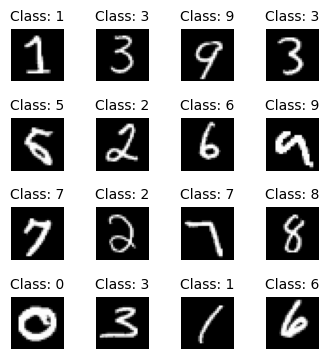

In [135]:
def show_dataset_sample(sample_size: int = 100):
  # sample_size must be a square number so the grid is all full
  loader = DataLoader(dataset, batch_size=sample_size, shuffle=True)
  x, y = next(iter(loader))
  x = x.view(sample_size, 1, 28, 28)
  y = y.view(sample_size)
  show_images(x, y)

show_dataset_sample(sample_size=16)

In [136]:
loader = DataLoader(dataset, batch_size=2, shuffle=True)
x, y = next(iter(loader))

In [137]:
x.shape, y.shape, y

(torch.Size([2, 784]), torch.Size([2]), tensor([6, 7]))

In [138]:
x[0].shape, y.shape

(torch.Size([784]), torch.Size([2]))

In [139]:
x.view(2, 1, 28, 28).shape

torch.Size([2, 1, 28, 28])

In [140]:
# x.view(x[0].size(0), -1)

## Select a device

In [141]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Selected Device:", device)

Selected Device: cpu


## Define the model

In [142]:
# TODO: Define your model(s) and loss function(s) here.
# You can add as many cells as you like.
# You can add utility functions related to the model here too.

In [143]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConditionalMADE(nn.Module):
    def __init__(self, input_size=784, hidden_size=500, cond_size=1, output_size=784):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.cond_size = cond_size
        self.output_size = output_size

        # Masks (single sequential)
        self.register_buffer('mask_input_hidden', torch.tril(torch.ones(input_size, hidden_size), diagonal=-1))
        self.register_buffer('mask_hidden_output', torch.tril(torch.ones(hidden_size, output_size), diagonal=-1))

        # Layers
        self.fc_in = nn.Linear(input_size + cond_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, y_cond):
        """
        x: [batch, 784] input
        y_cond: [batch] conditional information
        """
        # Combine input with condition
        y_cond = y_cond.view(-1,1)
        h = torch.cat([x, y_cond], dim=-1)

        # Hidden layer with mask
        h = self.fc_in(h)
        h = h * self.mask_input_hidden.sum(0)  # apply sequential mask
        h = F.relu(h)

        # Output layer with mask
        out = self.fc_out(h)
        out = out * self.mask_hidden_output.sum(0)
        return out  # logits

    @torch.no_grad()
    def sample(self, y_cond, device='cpu'):
        """
        Fast autoregressive sampling for Bernoulli MADE
        y_cond: [batch] conditional information
        """
        batch_size = y_cond.size(0)
        x = torch.zeros(batch_size, self.input_size, device=device)
        
        for i in range(self.input_size):
            logits = self.forward(x, y_cond)
            probs = torch.sigmoid(logits[:, i])
            x[:, i] = torch.bernoulli(probs)
        
        return x


## Define Hyperparameters

In [159]:
# TODO: Define the hyperparameters here.
input_dim = 28*28
hidden_dim = 500
actv = "relu"
grad_clip = 5.0
n_mixtures = 10
epochs = 100
batch_size = 64
lr = 1e-3
max_patience = 20

## Instantiate models and optimizers

In [145]:
# TODO: Instantiate the models and optimizers here.
#model = RNADE(input_dim=input_dim, hidden_dim=hidden_dim,  n_mixtures= n_mixtures).to(device)
#optimizer = optim.Adam(model.parameters(), lr=lr)
model = ConditionalMADE()

## Train the model

In [146]:
# TODO: Write the code to train the model here

In [157]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_made(name, model, dataloader, max_patience, epochs=10, lr=1e-3, device='cuda'):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()  # NLL for Bernoulli output

    nll_his = []
    best_nll = 1000.
    patience = 0
    
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        for x, y in tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}"):
            x = x.to(device)
            y_cond =  y.view(-1,1) #nn.functional.one_hot(y, num_classes=cond_size).float().to(device)

            optimizer.zero_grad()
            logits = model(x, y_cond)
            loss = criterion(logits, x)  # NLL
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x.size(0)
        nll_his.append(loss)
        if epoch == 0:
            print('saved!')
            torch.save(model.state_dict(), f"{name}.pth")
            best_nll = loss
        else:
            if loss < best_nll:
                print('saved!')
                torch.save(model.state_dict(), f"{name}.pth")
                best_nll = loss
                patience = 0
            else:
                patience = patience + 1

        if patience > max_patience:
            break
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch {epoch}: NLL loss = {epoch_loss:.4f}")
    nll_his = np.asarray(nll_his)

    return nll_his

In [160]:
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
loss_history = train_made("made_mnist-v4", model, train_loader, max_patience, epochs=10, lr=1e-3, device='cpu')

Epoch 1/10: 100%|██████████| 938/938 [00:17<00:00, 52.29it/s]


saved!
Epoch 1: NLL loss = 0.4310


Epoch 2/10: 100%|██████████| 938/938 [00:18<00:00, 51.85it/s]


saved!
Epoch 2: NLL loss = 0.4309


Epoch 3/10: 100%|██████████| 938/938 [00:17<00:00, 52.19it/s]


Epoch 3: NLL loss = 0.4310


Epoch 4/10: 100%|██████████| 938/938 [00:17<00:00, 53.13it/s]


Epoch 4: NLL loss = 0.4310


Epoch 5/10: 100%|██████████| 938/938 [00:17<00:00, 54.86it/s]


Epoch 5: NLL loss = 0.4309


Epoch 6/10: 100%|██████████| 938/938 [00:17<00:00, 54.69it/s]


saved!
Epoch 6: NLL loss = 0.4309


Epoch 7/10: 100%|██████████| 938/938 [00:17<00:00, 54.49it/s]


Epoch 7: NLL loss = 0.4309


Epoch 8/10: 100%|██████████| 938/938 [00:16<00:00, 55.27it/s]


Epoch 8: NLL loss = 0.4310


Epoch 9/10: 100%|██████████| 938/938 [00:16<00:00, 55.42it/s]


Epoch 9: NLL loss = 0.4309


Epoch 10/10: 100%|██████████| 938/938 [00:16<00:00, 55.48it/s]

Epoch 10: NLL loss = 0.4309


RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

In [149]:
#plot

torch.Size([64, 784]) torch.Size([64])


## [Optional] Save and/or load the model

In [150]:
## Optional TODO: Save the model if you want to store your work on disk and load it later
torch.save(model.state_dict(), "made_mnist.pth")

model = ConditionalMADE()
model.load_state_dict(torch.load("made_mnist.pth"))
model.eval()

ConditionalMADE(
  (fc_in): Linear(in_features=785, out_features=500, bias=True)
  (fc_out): Linear(in_features=500, out_features=784, bias=True)
)

## Write the generation function

In [161]:
# TODO: Rewrite the following function

# Given a tensor of classes y, this function conditionally generates a tensor images.
# Params:
# - y: A tensor of shape [Batch Size] and type int64 and resides on the CPU memory
# Return: A tensor of shape [Batch Size, 1, Height, Width] and type float32

def generate(y: torch.Tensor) -> torch.Tensor:
  #batch_size = y.shape[0]
  model.eval()
  new_x = model.sample(y)
  return new_x

## Generate some images and display them

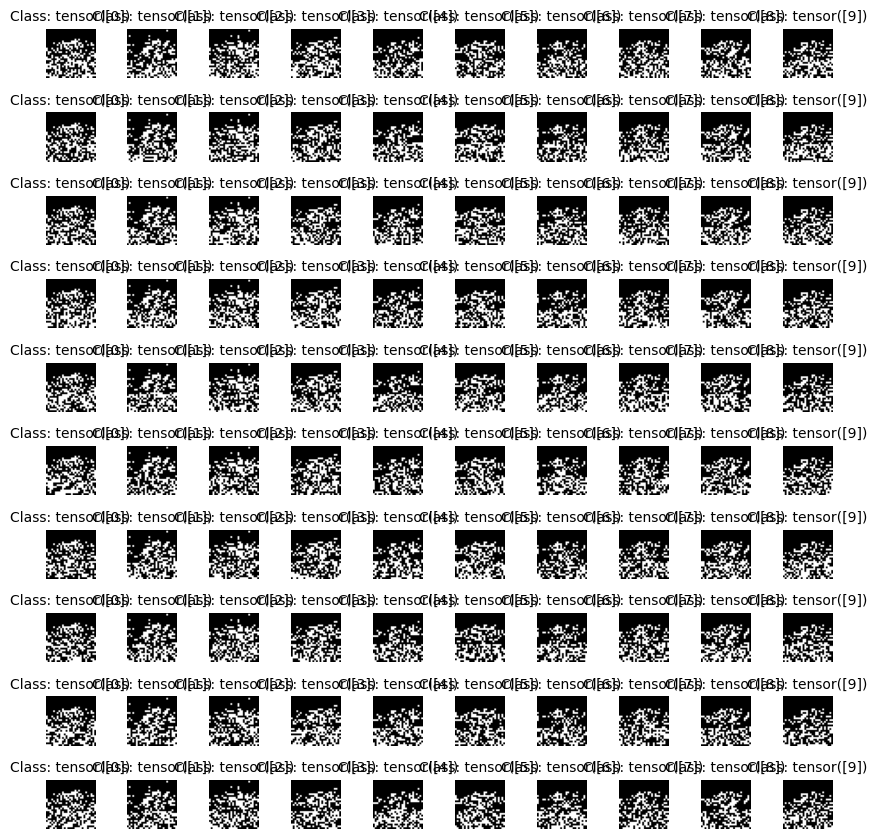

In [162]:
# Generate 100 images (10 images per class x 10 classes)
y = torch.tensor([[i for _ in range(10) for i in range(10)]], dtype=torch.long)
y = y.view(100,1)
x = generate(y)
show_images(x, y)

In [153]:
y = torch.tensor([i for _ in range(10) for i in range(10)], dtype=torch.long)
y = y.view(-1,1)
y.shape

torch.Size([100, 1])

In [154]:
x = torch.zeros(100, 28*28, device="cpu")
for i in range(28*28):
    h = torch.cat([x, y], dim=-1)
x.shape, h.shape

(torch.Size([100, 784]), torch.Size([100, 785]))

In [155]:
x.shape, y.shape
y.reshape(-1)
h.shape

torch.Size([100, 785])

In [156]:
x.shape

torch.Size([100, 784])

## [Optional] Extras

You can do any extra stuff you want here. Some examples are:
* Draw a graph of the loss functions.
* Implement interpolation in latent space (You can try it with Normalizing flows, Latent variable models and Implicit models).
* Implement image in-painting (You can try it with Score-based models, and in a limited form with Autoregressive models too).
* Visualize the generation process (You can try it with Energy-based and Score-based models).